<img src="images/logo.png" align="right" width="20%">

# Dissertation Early Draft:
# Training A Graph State Prediction Network

This notebook is a prototype on how to train a graph state prediction network using CNN and LSTM.
The content is devided into __3__ parts:

1. Data preprocessing and wrangling
2. Model building
3. Tuning and Training

The model is built with [PyTorch](https://pytorch.org/)


## Part 1: Data Preprocessing and Wrangling

### 1. Import necessary libraries:
We will use pandas and numpy as main data examine and cleansing util and use dask to handle parallel computing cases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy
import dask
import time
import psycopg2
import warnings
from PIL import Image
from scipy import stats
from matplotlib import pyplot as plt

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First, use a small sample data (approximately 1 million rows):

In [3]:
# Load already cleaned data sample
table = pd.read_csv('dataset/nytaxi_yellow_2017_jan.csv')
table.head()

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,trip_distance,passenger_count,total_amount,trip_time,trip_avg_speed,trip_time_sec
0,25754898,2017-01-09 11:13:00,2017-01-09 11:25:00,263,161,3.3,1,15.30,00:12:00,16.5,720
1,25754899,2017-01-09 11:32:00,2017-01-09 11:36:00,186,234,0.9,1,7.25,00:04:00,13.5,240
2,25754900,2017-01-09 11:38:00,2017-01-09 11:42:00,164,161,1.1,1,7.30,00:04:00,16.5,240
3,25754901,2017-01-09 11:52:00,2017-01-09 11:57:00,236,75,1.1,1,8.50,00:05:00,13.2,300
4,25754903,2017-01-01 00:00:00,2017-01-01 00:03:00,48,48,0.5,1,5.30,00:03:00,10.0,180



### 2. First sight of the data

Let's see the the type of columns and some basic statistics of the sample data:

In [4]:
table.dtypes

tripid                     int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
pulocationid               int64
dolocationid               int64
trip_distance            float64
passenger_count            int64
total_amount             float64
trip_time                 object
trip_avg_speed           float64
trip_time_sec              int64
dtype: object

In [5]:
table.shape

(1040001, 11)

In [6]:
table.describe()

,tripid,pulocationid,dolocationid,trip_distance,passenger_count,total_amount,trip_avg_speed,trip_time_sec
count,1.040001e+06,1.040001e+06,1.040001e+06,1.040001e+06,1.040001e+06,1.040001e+06,1.040001e+06,1.040001e+06
mean,2.627946e+07,1.610259e+02,1.591211e+02,3.033442e+00,1.681332e+00,1.552271e+01,1.294343e+01,9.029197e+02
std,3.026837e+05,6.767791e+01,7.193925e+01,3.800200e+00,1.291006e+00,1.342812e+01,1.041047e+01,3.373064e+03
min,2.575490e+07,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,-9.470000e+01,4.341534e-04,6.000000e+01
25%,2.601747e+07,1.130000e+02,1.070000e+02,1.000000e+00,1.000000e+00,8.160000e+00,8.400000e+00,3.600000e+02
50%,2.627957e+07,1.610000e+02,1.620000e+02,1.700000e+00,1.000000e+00,1.130000e+01,1.133333e+01,6.000000e+02
75%,2.654161e+07,2.320000e+02,2.330000e+02,3.200000e+00,2.000000e+00,1.680000e+01,1.530000e+01,9.600000e+02
max,2.680347e+07,2.650000e+02,2.650000e+02,1.517000e+02,6.000000e+00,1.000290e+03,1.914000e+03,8.640000e+04


The columns we will use are: **tpep_pickup_datetime, pulocationid, tpep_dropoff_datetime, dolocationid.**
These information are used to generate graphs that are used to discribe the general traffic state of New York.

Notice currently the **tpep_pickup_datetime** and **tpep_dropoff_datetime** are of type `object`:

In [7]:
table.loc[:,['tpep_pickup_datetime', 'tpep_dropoff_datetime']].head()

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2017-01-09 11:13:00,2017-01-09 11:25:00
1,2017-01-09 11:32:00,2017-01-09 11:36:00
2,2017-01-09 11:38:00,2017-01-09 11:42:00
3,2017-01-09 11:52:00,2017-01-09 11:57:00
4,2017-01-01 00:00:00,2017-01-01 00:03:00


In order to do **time slice** later, these two feilds must be sorted in chronological mananer, first by `tpep_pickup_datetime` and then by `tpep_dropoff_datetime`, as follows:

In [8]:
table.sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime']).head(10) # pick first 10 rows

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,trip_distance,passenger_count,total_amount,trip_time,trip_avg_speed,trip_time_sec
23,25754922,2017-01-01 00:00:00,2017-01-01 00:01:00,143,143,0.20,2,4.30,00:01:00,12.0,60
37,25754937,2017-01-01 00:00:00,2017-01-01 00:01:00,243,243,0.10,1,4.30,00:01:00,6.0,60
68,25754969,2017-01-01 00:00:00,2017-01-01 00:01:00,239,238,0.41,2,5.52,00:01:00,24.6,60
19,25754918,2017-01-01 00:00:00,2017-01-01 00:02:00,36,37,0.50,1,5.30,00:02:00,15.0,120
4,25754903,2017-01-01 00:00:00,2017-01-01 00:03:00,48,48,0.50,1,5.30,00:03:00,10.0,180
38,25754938,2017-01-01 00:00:00,2017-01-01 00:03:00,161,161,0.24,1,6.36,00:03:00,4.8,180
39,25754939,2017-01-01 00:00:00,2017-01-01 00:03:00,50,246,0.92,1,7.25,00:03:00,18.4,180
43,25754943,2017-01-01 00:00:00,2017-01-01 00:03:00,74,75,0.56,3,5.80,00:03:00,11.2,180
49,25754949,2017-01-01 00:00:00,2017-01-01 00:03:00,236,236,0.90,4,6.30,00:03:00,18.0,180
70,25754971,2017-01-01 00:00:00,2017-01-01 00:03:00,137,137,2.20,1,4.80,00:03:00,44.0,180


We can see from above that the taxi trips are nicely sorted according to **time**. What we need to do is convert this tabular date into graphs that described by **adjacency matrice**.

First, let's see what are `pulocationid` and `dolocationid`:

<img src="images/map.jpg" align="center" width="60%">

They are code number for a district in Manhattan, New York. We will mainly describe the traffic state and prediction at **this** level.

### 3. Time slicing

Now we've done a very superficial exploration of the data. It's time to convert the tabular data to graphs that are to be fed into our neural network model.

The first problem is, **how to decide a feasible time interval?**

Of course, the time interval should be a varaible that is to be selected **per need. However,** it is a reasonable thinking to let a time interval (i.e. a **snapshot**) to contain as many as **complete trip** as possible. See the diagram below:

<img src="images/snapshot.png" align="center" width="70%">

#### **If the time interval is too small**:

The majority of the matrices will be very sparse or even completely blank.

#### If the time interval is too big:

Then information about trips will be densely squeezed into one matrix and a lot of details on changes along time will be lost.

Thus, it is important to choose time interval wisely. Let's look at the data again:

In [9]:
table.loc[:,['trip_distance', 'trip_time_sec', 'trip_avg_speed']].describe()

,trip_distance,trip_time_sec,trip_avg_speed
count,1.040001e+06,1.040001e+06,1.040001e+06
mean,3.033442e+00,9.029197e+02,1.294343e+01
std,3.800200e+00,3.373064e+03,1.041047e+01
min,1.000000e-02,6.000000e+01,4.341534e-04
25%,1.000000e+00,3.600000e+02,8.400000e+00
50%,1.700000e+00,6.000000e+02,1.133333e+01
75%,3.200000e+00,9.600000e+02,1.530000e+01
max,1.517000e+02,8.640000e+04,1.914000e+03


The an average trip lasts for roughly 900 seconds, which is **15 minutes**.

The median(i.e. 50% percentile) is roughly 600 seconds, which is **10 minutes**.

Let's plot the distribution of column `trip_time_sec` to have a better intuition:

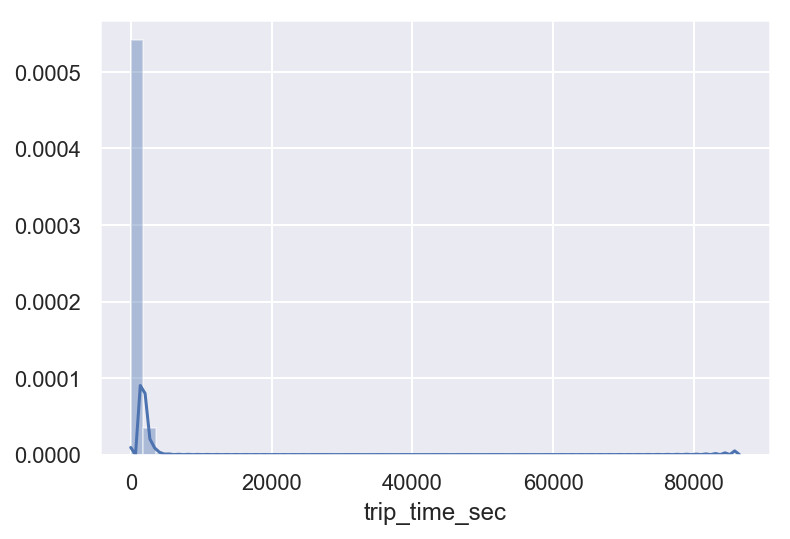

In [10]:
warnings.simplefilter('ignore')
sns.set(color_codes=True)
sns.distplot(table.loc[:,'trip_time_sec']);

It seems that the trips are mostly concentrated in a shorter time range, while some outliers may significantly biased the average.

Let's see how how many trips are longer than 30 minutes (1800 secs):

In [11]:
table.loc[table['trip_time_sec'] > 1800].shape[0] / 1040001 # divided by total number of rows

0.05949609663836862

In [12]:
table.loc[table['trip_time_sec'] > 900].shape[0] / 1040001

0.27779780980979824

There are **95%** of the trips last shorter than 30 minutes, let's plot distribution at this range:

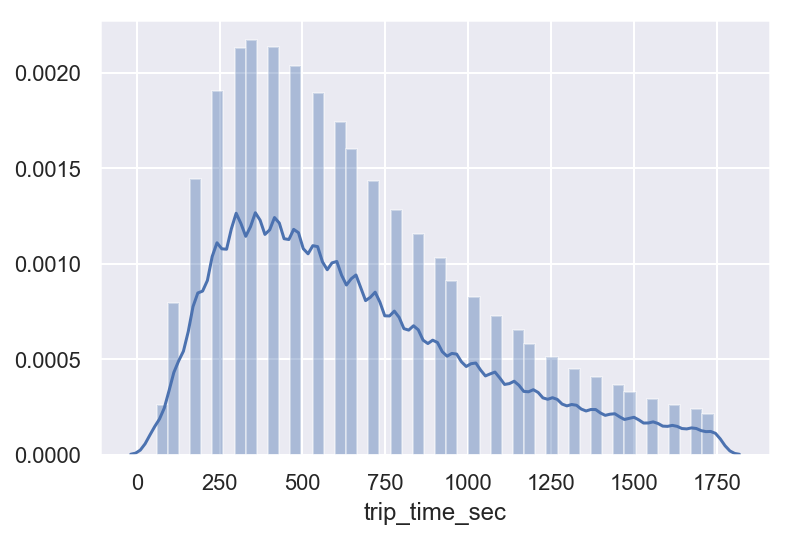

In [13]:
temp = table.loc[table['trip_time_sec'] < 1800]
sns.distplot(temp.loc[:,'trip_time_sec']);

In [14]:
temp.loc[:,['trip_distance', 'trip_time_sec', 'trip_avg_speed']].describe()

,trip_distance,trip_time_sec,trip_avg_speed
count,971920.000000,971920.000000,971920.000000
mean,2.383037,657.905136,12.557337
std,2.460777,387.336369,10.357605
min,0.010000,60.000000,0.024000
25%,0.990000,360.000000,8.400000
50%,1.600000,600.000000,11.142857
75%,2.800000,900.000000,14.820000
max,31.900000,1740.000000,1914.000000


More than 50% of the trips have trip time between 6 to 15 minutes, with a median of 10 minutes.

#### As a result, we primarily decide to use 10 minutes as time interval.

### 4. From tabular data to graph

Since we have decided a time interval, it's time to generate matrices. Basically, the idea is shown as figure below:

<img src="images/matrices.png" align="left" width="85%">


Apart from **outgoin** and **incoming** matrices shown above, an additional **Domestic** matrix is add because 50% of trips last less than the **chosen interval 10 minutes**. Such matrices can be combined into a **Tensor** illustrated as follows:

<img src="images/layers.png" align="center" width="35%">

#### STRICT DEFINITION OF OID layers

+ **O**utgoing layer
    Condition: 
    1. subtable sorted by tpep_**pickup**_datetime
    2. left bound of interval  <= tpep_pickup_datetime  < right bound of interval
    3. right bound of interval <= tpep_dropoff_datetime


+ **I**ncoming layer
    Condition: 
    1. subtable sorted by tpep_**dropoff**_datetime
    2. left bound of interval  <= tpep_dropoff_datetime  < right bound of interval
    3. tpep_pickup_datetime < left bound of interval


+ **D**omestic layer
    Condition: 
    1. subtable sorted by either tpep\_**pickup**\_datetime or tpep\_**dropoff**\_datetime, but only count **once*.
    2. left bound of interval  <= tpep_pickup_datetime < tpep_dropoff_datetime  < right bound of interval


#### Extract relevant columns:

To generate tensor defined above, **four** key columns are needed.They are `tpep_pickup_datetime`, `tpep_dropoff_datetime`, `pulocationid` and `dolocationid`.

We first extract them from original table:

In [15]:
# draw four needed columns and a id column, then sort according to time.
# the `tripid` column is for the sake of naming.
tensor_gen_o = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                      ].sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) # the first sort condition rules
tensor_gen_o.head()

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
23,25754922,2017-01-01 00:00:00,2017-01-01 00:01:00,143,143
37,25754937,2017-01-01 00:00:00,2017-01-01 00:01:00,243,243
68,25754969,2017-01-01 00:00:00,2017-01-01 00:01:00,239,238
19,25754918,2017-01-01 00:00:00,2017-01-01 00:02:00,36,37
4,25754903,2017-01-01 00:00:00,2017-01-01 00:03:00,48,48


#### Slice the table to sub-tables according to time interval (10 min)

Since the columns are extracted, now it's time to generate tensors.

The dataset is trip data of all yellow taxi cabs in Manhattan area in **January**, 2017.As we are making 10-minute-splices, there will be total:

$$
6 \times 24 \times 31 = 4464 \space slices(i.e. \space snapshots)
$$

Each slice has 3 layers, that is in total

$$
4464 \times 3 = 13392 \space matrices
$$
to be generated. 

First, let's try to generate one image (i.e. a *tensor* with **3** layers).

The time columns need to be converted to pandas timestamp type in order to compare:

In [16]:
# current type is python str
type(tensor_gen_o.iloc[0,1])

str

In [17]:
# convert to timestamp
pd.to_datetime(tensor_gen_o.iloc[0,1])

Timestamp('2017-01-01 00:00:00')

In [18]:
t1 = pd.to_datetime(tensor_gen_o.iloc[0,1]) # 2017-01-01 00:00:00
t2 = pd.to_datetime(tensor_gen_o.iloc[0,2]) # 2017-01-01 00:01:00
t1 < t2 # test if can compare time

True

In [19]:
# apply type cast to all values:
tensor_gen_o['tpep_pickup_datetime'] = pd.to_datetime(tensor_gen_o['tpep_pickup_datetime'])
tensor_gen_o['tpep_dropoff_datetime'] = pd.to_datetime(tensor_gen_o['tpep_dropoff_datetime'])

tensor_gen_o.dtypes

tripid                            int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
pulocationid                      int64
dolocationid                      int64
dtype: object

In [20]:
tensor_gen_o.head()

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
23,25754922,2017-01-01,2017-01-01 00:01:00,143,143
37,25754937,2017-01-01,2017-01-01 00:01:00,243,243
68,25754969,2017-01-01,2017-01-01 00:01:00,239,238
19,25754918,2017-01-01,2017-01-01 00:02:00,36,37
4,25754903,2017-01-01,2017-01-01 00:03:00,48,48


The interval **boundaries** are fixed when interval is set.

In [60]:
# create intervals
intervals = pd.date_range('2017-01-01 00:00:00', '2017-02-01 00:00:00', freq='10min')

intervals

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:10:00',
               '2017-01-01 00:20:00', '2017-01-01 00:30:00',
               '2017-01-01 00:40:00', '2017-01-01 00:50:00',
               '2017-01-01 01:00:00', '2017-01-01 01:10:00',
               '2017-01-01 01:20:00', '2017-01-01 01:30:00',
               ...
               '2017-01-31 22:30:00', '2017-01-31 22:40:00',
               '2017-01-31 22:50:00', '2017-01-31 23:00:00',
               '2017-01-31 23:10:00', '2017-01-31 23:20:00',
               '2017-01-31 23:30:00', '2017-01-31 23:40:00',
               '2017-01-31 23:50:00', '2017-02-01 00:00:00'],
              dtype='datetime64[ns]', length=4465, freq='10T')

**Notice**: When splicing time interval int such manner, we are assuming the **entire** month is monitored. Under this setting, we do not consider another day is a 'fresh start'.



In [61]:
intervals[1]

Timestamp('2017-01-01 00:10:00', freq='10T')

In [62]:
# First subtb:
first = tensor_gen_o.loc[tensor_gen_o['tpep_pickup_datetime'] < intervals[1]]
print(f'shape is: {first.shape}')
first.head()

shape is: (1751, 5)


,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
23,25754922,2017-01-01,2017-01-01 00:01:00,143,143
37,25754937,2017-01-01,2017-01-01 00:01:00,243,243
68,25754969,2017-01-01,2017-01-01 00:01:00,239,238
19,25754918,2017-01-01,2017-01-01 00:02:00,36,37
4,25754903,2017-01-01,2017-01-01 00:03:00,48,48


In [63]:
# sort to have a clearer look:
first.sort_values(by=['pulocationid', 'dolocationid']).head(20)

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
182869,25939738,2017-01-01 00:02:00,2017-01-01 00:09:00,4,79
183253,25940126,2017-01-01 00:04:00,2017-01-01 00:08:00,4,79
183415,25940290,2017-01-01 00:05:00,2017-01-01 00:10:00,4,79
183997,25940882,2017-01-01 00:08:00,2017-01-01 00:15:00,4,114
184070,25940955,2017-01-01 00:08:00,2017-01-01 00:11:00,4,224
183112,25939983,2017-01-01 00:03:00,2017-01-01 00:10:00,4,232
183426,25940301,2017-01-01 00:05:00,2017-01-01 00:17:00,4,249
182933,25939803,2017-01-01 00:02:00,2017-01-01 00:03:00,7,7
183105,25939976,2017-01-01 00:03:00,2017-01-01 00:06:00,7,7
183005,25939875,2017-01-01 00:03:00,2017-01-01 00:07:00,7,7


The `first` will generate Outgoing, Incoming and Domestic layers, that is, 3 matrices of size: 

$$
(number \space of\space zones)\space \times \space (number\space of\space zones)
$$

Let's see the zone numbers:

In [85]:
# Load zone lookup table
zones = pd.read_csv('dataset/taxi_zone_lookup.csv')
print(f'shape is: {zones.shape}')
zones

shape is: (265, 4)


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
5,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
6,7,Queens,Astoria,Boro Zone
7,8,Queens,Astoria Park,Boro Zone
8,9,Queens,Auburndale,Boro Zone
9,10,Queens,Baisley Park,Boro Zone


Total 265 zones, indexing from 0 to 264.

Among which, we only care about `Yellow Zone` or `Manhattan` area:

In [102]:
y_zone = zones.loc[zones['Borough'] == 'Manhattan']
print(y_zone.shape)
img_size = y_zone.shape[0]
y_zone

(69, 4)


,LocationID,Borough,Zone,service_zone
3,4,Manhattan,Alphabet City,Yellow Zone
11,12,Manhattan,Battery Park,Yellow Zone
12,13,Manhattan,Battery Park City,Yellow Zone
23,24,Manhattan,Bloomingdale,Yellow Zone
40,41,Manhattan,Central Harlem,Boro Zone
41,42,Manhattan,Central Harlem North,Boro Zone
42,43,Manhattan,Central Park,Yellow Zone
44,45,Manhattan,Chinatown,Yellow Zone
47,48,Manhattan,Clinton East,Yellow Zone
49,50,Manhattan,Clinton West,Yellow Zone


Thus, the layers should be matrices of size (265, 265), and each timeslice(snapshot) should be tensors of size (55, 55, 3).

Create the first tensor:

In [103]:
# convert dtype for entire table here:
table['tpep_pickup_datetime'] = pd.to_datetime(table['tpep_pickup_datetime'])
table['tpep_dropoff_datetime'] = pd.to_datetime(table['tpep_dropoff_datetime'])

# O,I,D layers of first snapshot defined:
tensor_gen_o = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                      ].sort_values(by=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) # the first sort condition rules

tensor_gen_I = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                      ].sort_values(by=['tpep_dropoff_datetime', 'tpep_pickup_datetime']) # the first sort condition rules

tensor_gen_D = table.loc[:,['tripid',
                          'tpep_pickup_datetime',
                          'tpep_dropoff_datetime',
                          'pulocationid', 'dolocationid']
                      ].sort_values(by=['tpep_dropoff_datetime', 'tpep_pickup_datetime']) # whichever is ok

# Their shape should be the same
assert tensor_gen_o.shape == tensor_gen_I.shape == tensor_gen_D.shape

# Check the condition of three layers above, if forgotten.
f_olayer = tensor_gen_o.loc[(tensor_gen_o['tpep_pickup_datetime'] < intervals[1]) &
                            (tensor_gen_o['tpep_pickup_datetime'] >= intervals[0]) &
                            (tensor_gen_o['tpep_dropoff_datetime'] >= intervals[1])
                           ]

f_Ilayer = tensor_gen_I.loc[(tensor_gen_I['tpep_pickup_datetime'] < intervals[0]) &
                            (tensor_gen_I['tpep_dropoff_datetime'] >= intervals[0]) &
                            (tensor_gen_I['tpep_dropoff_datetime'] < intervals[1])
                           ]

f_Dlayer = tensor_gen_D.loc[(tensor_gen_D['tpep_pickup_datetime'] >= intervals[0]) &
                            (tensor_gen_D['tpep_dropoff_datetime'] < intervals[1])
                           ]

print(f'f_olayer.shape: {f_olayer.shape}')
print(f'f_Ilayer.shape: {f_Ilayer.shape}') # There will be no incoming trips for the first snapshot.
print(f'f_Dlayer.shape: {f_Dlayer.shape}')

f_olayer.shape: (1545, 5)
f_Ilayer.shape: (0, 5)
f_Dlayer.shape: (206, 5)


In [94]:
# Check if the trips add up:
assert first.shape[0] == f_olayer.shape[0] + f_Ilayer.shape[0] + f_Dlayer.shape[0]
f_olayer.head(20)

,tripid,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid
28,25754928,2017-01-01,2017-01-01 00:10:00,239,48
83,25754985,2017-01-01,2017-01-01 00:10:00,113,137
10,25754909,2017-01-01,2017-01-01 00:11:00,142,236
54,25754954,2017-01-01,2017-01-01 00:11:00,264,264
74,25754976,2017-01-01,2017-01-01 00:11:00,162,45
21,25754920,2017-01-01,2017-01-01 00:12:00,125,45
25,25754924,2017-01-01,2017-01-01 00:12:00,68,48
41,25754941,2017-01-01,2017-01-01 00:12:00,138,80
53,25754953,2017-01-01,2017-01-01 00:12:00,113,229
61,25754962,2017-01-01,2017-01-01 00:12:00,263,7


Each pair of (pulocationid - 1, dolocationid - 1) indicates adding one to the snapshot:

Before generating image, we have to map the zone id to a range from 0 to 54:

In [129]:
real_id = list(map(str, list(y_zone.loc[:,'LocationID'])))
conv_id = [i for i in range(img_size)]
assert len(real_id) == len(conv_id)
mp = dict(zip(real_id, conv_id))
# the line below is a dirty fix, be causious in future!

In [122]:
# create a snapshot:
first_snapshot = np.zeros([img_size, img_size, 3], dtype='float64')
print(first_snapshot.shape)
print(first_snapshot[1,2,1])

left_zones = set()

for _, row in f_olayer.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 0] += 1 # inplace increment 1 in numpy
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

for _, row in f_Ilayer.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 1] += 1
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

for _, row in f_Dlayer.iterrows():
    try:
        first_snapshot[mp[str(row['pulocationid'])], mp[str(row['dolocationid'])], 2] += 1
    except Exception as e:
        left_zones.add(str(row['pulocationid']))
        left_zones.add(str(row['dolocationid']))

print(f'left_zones: {left_zones}')
print(f'left_zones length: {len(left_zones)}')

print(f'O max -> {first_snapshot[:,:,0].max()}')
print(f'I max -> {first_snapshot[:,:,1].max()}')
print(f'D max -> {first_snapshot[:,:,2].max()}')

# convert numpy array to a image:
tb = pd.DataFrame(first_snapshot[:,:,0])


first_snapshot *= 255//first_snapshot.max()

(69, 69, 3)
0.0
left_zones: {'142', '62', '25', '213', '182', '198', '238', '165', '137', '88', '144', '179', '140', '148', '97', '260', '126', '226', '90', '255', '65', '125', '50', '12', '33', '76', '134', '235', '107', '48', '4', '168', '53', '80', '189', '242', '138', '75', '114', '42', '47', '26', '217', '193', '263', '37', '92', '228', '71', '73', '28', '211', '170', '7', '82', '130', '183', '69', '225', '68', '166', '181', '13', '256', '229', '174', '66', '41', '233', '265', '106', '220', '108', '247', '35', '187', '248', '70', '232', '43', '163', '141', '147', '160', '10', '93', '45', '52', '173', '17', '89', '22', '18', '236', '161', '159', '262', '200', '112', '61', '231', '51', '164', '85', '20', '223', '230', '145', '129', '77', '157', '246', '192', '162', '113', '239', '188', '14', '91', '40', '243', '224', '119', '36', '177', '49', '186', '264', '249', '74', '72', '158', '79', '146', '132', '38', '234', '190', '95', '151', '216'}
left_zones length: 141
O max -> 8.0
I max 

In [ ]:
# Plot OID layer values:
temp_o = np.reshape(first_snapshot[:,:,0], (1,-1))
temp_i = np.reshape(first_snapshot[:,:,1], (1,-1))
temp_d = np.reshape(first_snapshot[:,:,2], (1,-1))

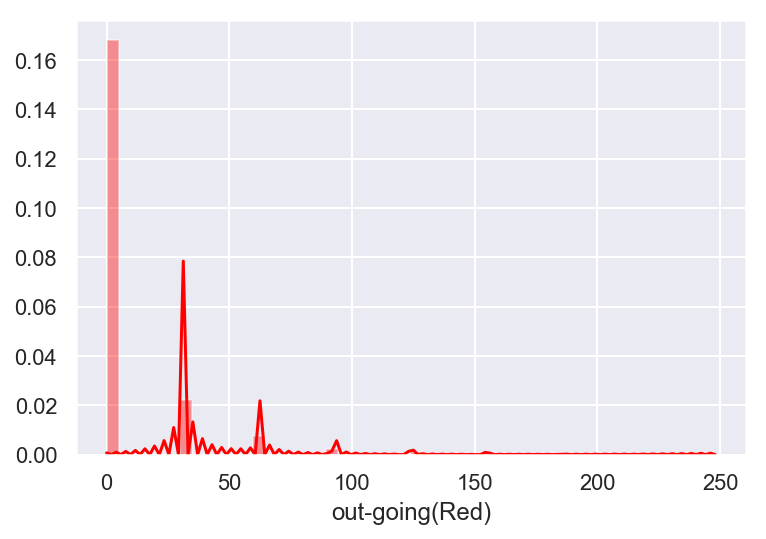

In [143]:
sns.distplot(temp_o, axlabel='out-going(Red)', color='red');

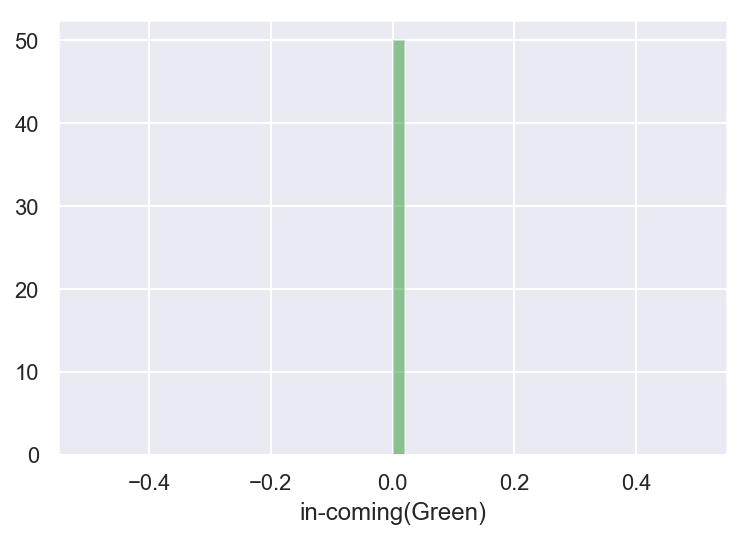

In [144]:
sns.distplot(temp_i, axlabel='in-coming(Green)', color='green');

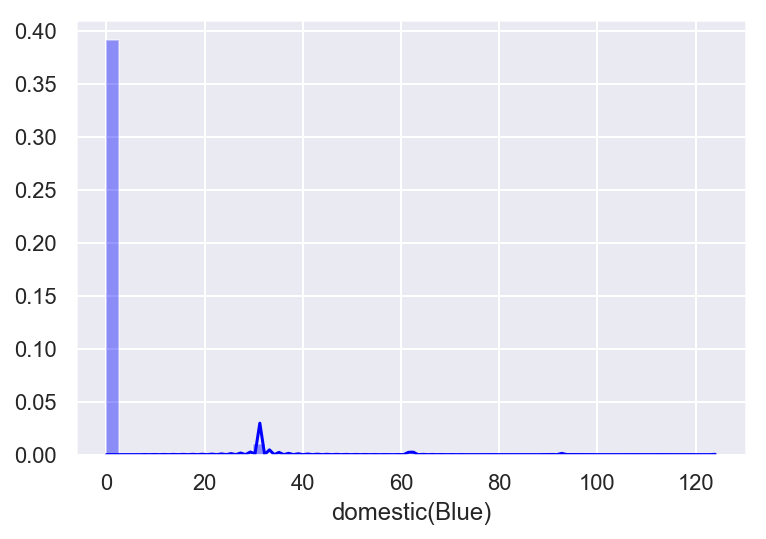

In [145]:
sns.distplot(temp_d, axlabel='domestic(Blue)', color='blue');

In [140]:
first_snapshot = first_snapshot.astype('uint8')
first_image = Image.fromarray(first_snapshot)

In [141]:
tb

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,31.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,31.0,62.0,31.0,31.0,0.0,0.0,124.0,124.0,...,0.0,0.0,62.0,31.0,0.0,62.0,0.0,31.0,0.0,31.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0


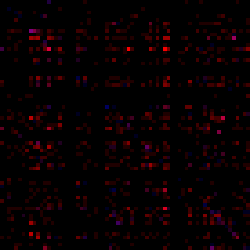

In [142]:
first_image.resize((250,250))

Now, slice the `tensor_gen` into 4464 sub tables: